## TO-DO/BUGS/Considerations

### BUGS

- When introducing the ECG as feature, the prediction gives nan values. Need to try to implement a single feature LSTM autoencoder on the ECG and see if the behaviour is different

- Pad sequences with the mean of the feature may force the autoencoder to learn the mean instead the original ditribution. This problem occurs with HR,RR and DBP. TIME_STEP has to be setted to minimum lenght of features sequences.

### TO-DO

- Threshold for anomaly = mean of the reconstruction error for healthy patients (resubstitution error). Above this threshold we can detect an anomaly.

### Questions

- To-do: can the resubstitution error be used as a threshold? Yes, to use in the confusion matrix.
- Data manipulation: replacing values and choose the appropriate TIME_STEP

### Considerations

- Nel caricare i dati la maggior parte dei sample era costituito da valori NaN. Una volta rimossi si ottengono dei valori con dei picchi, dovuti all'aver reso contigui valori che prima non lo erano.
- Rimossi i record che hanno una lunghezza pari a zero o una media negativa.
- L'errore di ricostruzione è minore usando la normalizzazione minmax, probabilmente perchè i dati non hanno una distribuzione gaussiana
- TIME_STEP maggiori degradano le prestazioni

## Environment setup

In [1]:
import vitaldb
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import operator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed
import tensorflow as tf

from keras import regularizers


2023-04-02 19:55:38.999486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data load

### API data load

In [79]:

def load_from_API(type='a',n_cases=None, asa = 3 , op = '<'):

    ops = {'>': operator.gt,
       '<': operator.lt,
       '>=': operator.ge,
       '<=': operator.le,
       '==': operator.eq}

    caseids_all = vitaldb.find_cases(['ECG_II','ART_DBP','ART_SBP','BT','HR','RR']) # find ids of patient with this parameters
    
    df = pd.read_csv('https://api.vitaldb.net/cases') # Load dataset
    df = df[ops[op](df['asa'], asa)] # ASA param identifies the health status of the patient

    caseids_unhealthy = df['caseid'].to_numpy() 
    caseids = [el for el in caseids_all if el in caseids_unhealthy]

    if(n_cases is None):
        n_cases = len(caseids)

    ecg = []
    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

    if(type in ('a','n','w')):

        if(type in ('a','n')):

            # load all the patients data 
            for i in range(0,n_cases): # Select only five patient for testing purpose; then len(caseids)
                try:
                    vals = vitaldb.load_case(caseids[i], ['ART_DBP','ART_SBP','BT','HR','RR'])
                    dbp.append(vals[:,0])
                    sbp.append(vals[:,1])
                    bt.append(vals[:,2])
                    hr.append(vals[:,3])
                    rr.append(vals[:,4])

                    # extract non-null values
                    dbp[i] = dbp[i][~np.isnan(dbp[i])]  
                    sbp[i] = sbp[i][~np.isnan(sbp[i])] 
                    bt[i] = bt[i][~np.isnan(bt[i])]
                    hr[i] = hr[i][~np.isnan(hr[i])] 
                    rr[i] = rr[i][~np.isnan(rr[i])]

                except Exception as e: 
                    print('\n=================\n')
                    print('INDEX: '+str(i))
                    print('ERROR: '+str(type(e)))
                    print('\n=================\n')
                    pass

        if(type in ('a','w')):
            for i in range(0,n_cases):
                #vals = vitaldb.load_case(caseids[i], ['ECG_II'], 0.01) #parameter 0.01 for a 'zoomed' ecg
                vals = vitaldb.load_case(caseids[i], ['ECG_II'])
                ecg.append(vals[:,0])
    
    return ecg,dbp,sbp,bt,hr,rr



### Disk data load

In [4]:
def load_from_disk(path):
    
    ecg = []
    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

# save the data into a file since loading all the 2k caseids requires at least 1h
    filepath = os.path.join(path,'numeric_data.vitaldb')
    ecgpath = os.path.join(path,'ecg_data.vitaldb')
    #ecgpath = '/Volumes/Windows/SIIA/ecg_data.vitaldb'

    with open(ecgpath, 'rb') as f:
        (ecg) = pickle.load(f)
    with open(filepath, 'rb') as f:
        (dbp,sbp,bt,hr,rr) = pickle.load(f)
    
    return ecg,dbp,sbp,bt,hr,rr

In [5]:
def save_to_disk(path,ecg,dbp,sbp,bt,hr,rr):
# save the data into a file since loading all the 2k caseids requires at least 1h

    with open(os.path.join(path,'numeric_data.vitaldb'), 'wb') as f:
        pickle.dump((dbp,sbp,bt,hr,rr), f)

    with open(os.path.join(path,'ecg_data.vitaldb'), 'wb') as f:
        pickle.dump(ecg, f)



## save the data into a file since loading all the 2k caseids requires at least 1h
#filepath = '/Users/Roberto/projects/siiaproject-vitanomaly/data.vitaldb'
#ecgpath = '/Volumes/Windows/SIIA/ecg_data.vitaldb'
#ecgpath = '/Users/Roberto/projects/siiaproject-vitanomaly/ecg_data.vitaldb'


### Visualize

In [6]:
def plot_data(ecg,dbp,sbp,bt,hr,rr,val = None):
    
    if(val == None or not isinstance(val,int)):
        val = np.argmin(np.array([
                         min([len(el) for el in ecg]),
                         min([len(el) for el in dbp]),
                         min([len(el) for el in sbp]),
                         min([len(el) for el in  bt]),
                         min([len(el) for el in  hr]),
                         min([len(el) for el in  rr])]))
        print(val)
    
    plt.figure(figsize=(20,20))
    plt.subplot(611)
    plt.title("ECG")
    for el in ecg:
        plt.plot(el)
    plt.subplots_adjust(hspace=1.)
    plt.subplot(612)
    plt.title("DBP")
    for el in dbp:
        plt.plot(el, color='b')
    plt.subplots_adjust(hspace=1.)
    plt.subplot(613)
    plt.title("SBP")
    for el in sbp:
        plt.plot(el, color='r')

    plt.subplot(614)
    plt.title("Body temperature")
    for el in bt:
        plt.plot(el, color='orange')

    plt.subplot(615)
    plt.title("Heart rate")
    for el in hr:
        plt.plot(el, color='r')

    plt.subplot(616)
    plt.title("Respiratory rate")
    for el in rr:
        plt.plot(el, color='g')
    plt.show()

## Preprocessing

In [7]:
def clean_data(ecg,dbp,sbp,bt,hr,rr):
# remove empty or with negative mean time series 

    try:
        for i in range(0,len(ecg) - len([el for el in ecg if len(el) == 0 or (np.mean(el) <= 0)])): 
            if(len(ecg[i])==0 or (np.mean(ecg[i]) <= 0)):
                ecg.pop(i)
    except:
        pass

    try:
        for i in range(0,len(dbp) - len([el for el in dbp if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(dbp[i])==0 or (np.mean(dbp[i]) <= 0)):
                dbp.pop(i)
    except:
        pass

    try:
        for i in range(0,len(sbp) - len([el for el in sbp if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(sbp[i])==0 or (np.mean(sbp[i]) <= 0)):
                sbp.pop(i)
    except:
        pass

    try:
        for i in range(0,len(bt) - len([el for el in bt if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(bt[i])==0 or (np.mean(bt[i]) <= 0)):
                bt.pop(i)
    except:
        pass

    try:
        for i in range(0,len(hr) - len([el for el in hr if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(hr[i])==0 or (np.mean(hr[i]) <= 0)):
                hr.pop(i)
    except:
        pass

    try:
        for i in range(0,len(rr) - len([el for el in rr if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(rr[i])==0 or (np.mean(rr[i]) <= 0)):
                rr.pop(i)
    except:
        pass

    return ecg,dbp,sbp,bt,hr,rr




def mean_norm(ecg,dbp,sbp,bt,hr,rr):


    flat_list_ecg = np.asarray([item for sublist in ecg for item in sublist],dtype='float64')
    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt  for item in sublist],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist],dtype='float64')
    #print({'dbp':len(flat_list_dbp),'sbp':len(flat_list_sbp),'hr':len(flat_list_hr),'bt':len(flat_list_bt),'rr':len(flat_list_rr)})
    print({'dbp':len(dbp),'sbp':len(sbp),'hr':len(hr),'bt':len(bt),'rr':len(rr)})


    ecg_mean,ecg_std = np.mean(flat_list_ecg),np.std(flat_list_ecg)
    dbp_mean,dbp_std = np.mean(flat_list_dbp),np.std(flat_list_dbp)
    sbp_mean,sbp_std = np.mean(flat_list_sbp),np.std(flat_list_sbp)
    bt_mean,bt_std = np.mean(flat_list_bt),np.std(flat_list_bt)
    hr_mean,hr_std = np.mean(flat_list_hr),np.std(flat_list_hr)
    rr_mean,rr_std = np.mean(flat_list_rr),np.std(flat_list_rr)

    print('\nMean values for features:')
    print({'ecg':ecg_mean,'dbp':dbp_mean,'sbp':sbp_mean,'hr':hr_mean,'bt':bt_mean,'rr':rr_mean})
    print('\nStd values for features:')
    print({'ecg':ecg_std,'dbp':dbp_std,'sbp':sbp_std,'hr':hr_std,'bt':bt_std,'rr':rr_std})
    print('\n')

    # Consider runtime warnings such as Divide by zero as Exceptions to throw
    old_settings = np.seterr(divide='raise')
    idx_remove = {}
    idx_remove['ecg'] = []
    idx_remove['sbp'] = []
    idx_remove['dbp'] = []
    idx_remove['bt'] = []
    idx_remove['rr'] = []
    idx_remove['hr'] = []
    

    for i in range(0,len(ecg)): 
        try:
            ecg[i][np.argwhere(ecg[i] < 0)] = np.mean(ecg[i])
            ecg[i] = (ecg[i] - ecg_mean)/(ecg_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['ecg'].append(i)
                

    for i in range(0,len(dbp)): 
        try:
            dbp[i][np.argwhere(dbp[i] <= 30)] = np.mean(dbp[i])
            dbp[i] = (dbp[i] - dbp_mean)/(dbp_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['dbp'].append(i)



    for i in range(0,len(sbp)): 
        try:
            sbp[i][np.argwhere(sbp[i] <= 70 )] = np.mean(sbp[i])
            sbp[i] = (sbp[i] - sbp_mean)/(sbp_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['sbp'].append(i)
        


    for i in range(0,len(bt)): 
        try:
            bt[i][np.argwhere(bt[i] <= 33)] = np.mean(bt[i])
            bt[i] = (bt[i] - bt_mean)/(bt_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['bt'].append(i)


    for i in range(0,len(hr)): 
        try:
            hr[i][np.argwhere(hr[i] <= 35)] = np.mean(hr[i])
            hr[i] = (hr[i] - hr_mean)/(hr_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['hr'].append(i)

    for i in range(0,len(rr)): 
        try:
            rr[i][np.argwhere(rr[i] <= 8)] = np.mean(rr[i])
            rr[i] = (rr[i] - rr_mean)/(rr_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['hr'].append(i)

    # Back to default settings for errors
    np.seterr(**old_settings)

    return ecg,dbp,sbp,bt,hr,rr,idx_remove





def minmax_norm(ecg,dbp,sbp,bt,hr,rr):


    flat_list_ecg = np.asarray([item for sublist in ecg for item in sublist],dtype='float64')
    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt  for item in sublist],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist],dtype='float64')
    #print({'dbp':len(flat_list_dbp),'sbp':len(flat_list_sbp),'hr':len(flat_list_hr),'bt':len(flat_list_bt),'rr':len(flat_list_rr)})


    ecg_min,ecg_max = np.min(flat_list_ecg),np.max(flat_list_ecg)
    dbp_min,dbp_max = np.min(flat_list_dbp),np.max(flat_list_dbp)
    sbp_min,sbp_max = np.min(flat_list_sbp),np.max(flat_list_sbp)
    bt_min,bt_max = np.min(flat_list_bt),np.max(flat_list_bt)
    hr_min,hr_max = np.min(flat_list_hr),np.max(flat_list_hr)
    rr_min,rr_max = np.min(flat_list_rr),np.max(flat_list_rr)
    
    old_settings = np.seterr(divide='raise')
    idx_remove = {}
    idx_remove['ecg'] = []
    idx_remove['sbp'] = []
    idx_remove['dbp'] = []
    idx_remove['bt'] = []
    idx_remove['rr'] = []
    idx_remove['hr'] = []

    for i in range(0,len(ecg)): 
        try:
            ecg[i][np.argwhere(ecg[i]<0)] = np.mean(ecg[i])
            ecg[i] = (ecg[i] - ecg_min)/(ecg_max - ecg_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['ecg'].append(i)


    for i in range(0,len(dbp)): 
        try:
            dbp[i][np.argwhere(dbp[i]<=30)] = np.mean(dbp[i])
            dbp[i] = (dbp[i] - dbp_min)/(dbp_max - dbp_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['dbp'].append(i)


    for i in range(0,len(sbp)): 
        try:
            sbp[i][np.argwhere(sbp[i] <= 70)] = np.mean(sbp[i])
            sbp[i] = (sbp[i] - sbp_min)/(sbp_max - sbp_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['sbp'].append(i)


    for i in range(0,len(bt)): 
        try:
            bt[i][np.argwhere(bt[i]<=33)] = np.mean(bt[i])
            bt[i] = (bt[i] - bt_min)/(bt_max - bt_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['bt'].append(i)


    for i in range(0,len(hr)): 
        try:
            #hr[i][np.argwhere(hr[i]<=35)] = np.mean(hr[i])
            hr[i] = (hr[i] - hr_min)/(hr_max - hr_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['hr'].append(i)


    for i in range(0,len(rr)): 
        try:
            #rr[i][np.argwhere(rr[i]<=8)] = np.mean(rr[i])
            rr[i] = (rr[i] - rr_min)/(rr_max - rr_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['rr'].append(i)


    # Back to default settings for errors
    np.seterr(**old_settings)

    return ecg,dbp,sbp,bt,hr,rr,idx_remove



def get_preprocessed_data(path, norm_func = None):

    ecg,dbp,sbp,bt,hr,rr = load_from_disk(path=path)
    ecg,dbp,sbp,bt,hr,rr = clean_data(ecg,dbp,sbp,bt,hr,rr)

    if(norm_func is not None):
        ecg,dbp,sbp,bt,hr,rr,idx_remove = norm_func(ecg,dbp,sbp,bt,hr,rr)
        
    idx_remove = []
    return ecg,dbp,sbp,bt,hr,rr,idx_remove


In [8]:
path = '/Users/Roberto/projects/AnomalyDetection/data/processed'
norm = 'minmax'
try:
    func_norm = norm + '_norm'
    normalize = globals()[func_norm] # normalize is called later for test data normalization
except:
    normalize = None

ecg,dbp,sbp,bt,hr,rr,idx_remove = get_preprocessed_data(path = path,norm_func = normalize)

# LSTM Autoencoder

In [49]:
# TIME_STEP of preprocess function should be equal to the minimum length of features sequences
min_seq_len = np.min([np.mean([len(el) for el in dbp]),np.mean([len(el) for el in sbp]),np.mean([len(el) for el in bt]),np.mean([len(el) for el in rr]),np.mean([len(el) for el in hr])])
min_seq_len

5432.817107093185

In [63]:
def preprocess(ecg,dbp,sbp,bt,hr,rr, TIME_STEP = 5500, n_instances = None):

    flat_list_ecg = np.asarray([item for sublist in ecg for item in sublist],dtype='float64')
    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt for item in sublist],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist],dtype='float64')
    #print({'ecg': len(flat_list_ecg),'dbp':len(flat_list_dbp),'sbp':len(flat_list_sbp),'hr':len(flat_list_hr),'bt':len(flat_list_bt),'rr':len(flat_list_rr)})


    X_ecg = []
    X_dbp = []
    X_sbp = []
    X_bt = []
    X_hr = []
    X_rr = []

    for seq in range(0,len(flat_list_ecg), TIME_STEP):
        X_ecg.append(flat_list_ecg[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_dbp), TIME_STEP):
        X_dbp.append(flat_list_dbp[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_sbp), TIME_STEP):
        X_sbp.append(flat_list_sbp[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_bt), TIME_STEP):
        X_bt.append(flat_list_bt[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_hr), TIME_STEP):
        X_hr.append(flat_list_hr[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_rr), TIME_STEP):
        X_rr.append(flat_list_rr[seq:seq+TIME_STEP])

    X_ecg = np.asarray(X_ecg,dtype=object)
    X_dbp = np.asarray(X_dbp,dtype=object)
    X_sbp = np.asarray(X_sbp,dtype=object)
    X_bt = np.asarray(X_bt,dtype=object)
    X_hr = np.asarray(X_hr,dtype=object)
    X_rr = np.asarray(X_rr,dtype=object)


    X_ecg = pad_sequences(X_ecg, TIME_STEP,padding='post',value = np.mean(flat_list_ecg),dtype='float64')
    X_dbp = pad_sequences(X_dbp, TIME_STEP,padding='post',value = np.mean(flat_list_dbp),dtype='float64')
    X_sbp = pad_sequences(X_sbp, TIME_STEP,padding='post',value = np.mean(flat_list_sbp),dtype='float64')
    X_bt = pad_sequences(X_bt, TIME_STEP,padding='post',value = np.mean(flat_list_bt),dtype='float64')
    X_hr = pad_sequences(X_hr, TIME_STEP,padding='post',value = np.mean(flat_list_hr),dtype='float64')
    X_rr = pad_sequences(X_rr, TIME_STEP,padding='post',value = np.mean(flat_list_rr),dtype='float64')


    X_ecg = np.asarray(np.expand_dims(X_ecg,axis=2))
    X_dbp = np.asarray(np.expand_dims(X_dbp,axis=2))
    X_sbp = np.asarray(np.expand_dims(X_sbp,axis=2))
    X_bt = np.asarray(np.expand_dims(X_bt,axis=2))
    X_hr = np.asarray(np.expand_dims(X_hr,axis=2))
    X_rr = np.asarray(np.expand_dims(X_rr,axis=2))


    min_len = np.min([X_dbp.shape[0],X_sbp.shape[0],X_bt.shape[0],X_hr.shape[0],X_rr.shape[0]])
    
    X_ecg = X_ecg[:min_len,:]
    X_dbp = X_dbp[:min_len,:]
    X_sbp = X_sbp[:min_len,:]
    X_bt = X_bt[:min_len,:]
    X_hr = X_hr[:min_len,:]
    X_rr = X_rr[:min_len,:]

    Y = np.concatenate([X_dbp, X_sbp, X_bt, X_hr, X_rr],axis=2)
    
    if(isinstance(n_instances,int) and n_instances > 0):
        X = Y[:n_instances] # Select the first n instances
    else:
        X = Y

    return X



def eval_error(X_test,res,out = False):

    n = min(X_test.shape[0],res.shape[0])
    overall_mean = 0

    dict_means = {}
    dict_means['sbp'] = 0
    dict_means['dbp'] = 0
    dict_means['bt'] = 0
    dict_means['rr'] = 0
    dict_means['hr'] = 0

    dic = {}
    dic[0] = 0
    dic[1] = 0
    dic[2] = 0
    dic[3] = 0
    dic[4] = 0
    
    for p in range(0,n):

        if(out):
            print('\tTest instance ' + str(p))

        tot = 0
        for i in range(0,5):
            re = np.round(np.linalg.norm(X_test[p,:,i] - res[p,:,i],2),3)
            tot = tot + re            
            dic[i] = dic[i] + re

            if(out):
                print('Reconstrucion error on feature ' + str(i) + ': ' + \
                      str(re)+'\n')

        mean = np.round(tot/5,3)
        overall_mean = overall_mean + mean
        
        if(out):
            print('Mean reconstruction error: ' + str(mean))
            print('\n')

    dict_means['sbp'] = np.round(dic[0]/n,3)
    dict_means['dbp'] = np.round(dic[1]/n,3)
    dict_means['bt'] = np.round(dic[2]/n,3)
    dict_means['rr'] = np.round(dic[3]/n,3)
    dict_means['hr'] = np.round(dic[4]/n,3)

    del dic
        
    overall_mean = overall_mean/n
    return overall_mean,dict_means



def plot_predict(X_test, res, figsize=(40,40), n = None, single = False):

    plt.figure(figsize=figsize)
    
    if(n is not None and isinstance(n,int) and n > -1):
        if(single):
            for j in range(0,5):
                s = '61'+str(j+1)
                plt.subplot(int(s))
                plt.subplots_adjust(hspace=1.)
                plt.title('Feature ' + str(j+1))
                plt.plot(res[n,:,j],'-r',linewidth=2.5,)
                plt.plot(X_test[n,:,j],'-g',linewidth=2.5,alpha=0.8)
            plt.show()
        else:
            for j in range(0,5):
                for i in range(0,n):
                    s = '61'+str(j+1)
                    plt.subplot(int(s))
                    plt.subplots_adjust(hspace=1.)
                    plt.title('Feature ' + str(j+1))
                    plt.plot(res[i,:,j],'-r',linewidth=2.5,)
                    plt.plot(X_test[i,:,j],'-g',linewidth=2.,alpha=0.5)
            plt.show()
    else:
        n = X_test.shape[0]
        for j in range(0,5):
            for i in range(0,n):
                s = '61'+str(j+1)
                plt.subplot(int(s))
                plt.subplots_adjust(hspace=1.)
                plt.title('Feature ' + str(j+1))
                plt.plot(res[i,:,j],'-r',linewidth=2.5,)
                plt.plot(X_test[i,:,j],'-g',linewidth=2.,alpha=0.5)

        plt.show()


In [15]:
X_train = preprocess(ecg,dbp,sbp,bt,hr,rr)
batch_size, seq_len, n_features = X_train.shape

model = Sequential()
model.add(LSTM(256, bias_regularizer=regularizers.l2(0.7),  recurrent_regularizer=regularizers.l2(0.6) , input_shape=(seq_len, n_features),return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(LSTM(128,    bias_regularizer=regularizers.l2(0.7),  recurrent_regularizer=regularizers.l2(0.6),   return_sequences=True))
model.add(LSTM(64,  bias_regularizer=regularizers.l1(0.7), recurrent_regularizer=regularizers.l2(0.6),  return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model.add(LSTM(128,    bias_regularizer=regularizers.l2(0.7),  recurrent_regularizer=regularizers.l2(0.6),   return_sequences=True))
model.add(LSTM(256,   bias_regularizer=regularizers.l2(0.7), recurrent_regularizer=regularizers.l2(0.6),  return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

2023-04-02 19:56:14.603283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5500, 256)         268288    
                                                                 
 dropout (Dropout)           (None, 5500, 256)         0         
                                                                 
 lstm_1 (LSTM)               (None, 5500, 128)         197120    
                                                                 
 lstm_2 (LSTM)               (None, 5500, 64)          49408     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5500, 64)          0         
                                                                 
 lstm_3 (LSTM)               (None, 5500, 128)         98816     
                                                                 
 lstm_4 (LSTM)               (None, 5500, 256)         3

In [17]:
history = model.fit(X_train, X_train, batch_size=64,validation_split=0.1, epochs=5,shuffle=False,verbose=1)

Epoch 1/5
40/40 [==============================] - 3017s 75s/step - loss: 794.4105 - val_loss: 617.9689
Epoch 2/5
40/40 [==============================] - 2943s 74s/step - loss: 557.3537 - val_loss: 512.7026
Epoch 3/5
40/40 [==============================] - 2979s 75s/step - loss: 486.4010 - val_loss: 462.0602
Epoch 4/5
40/40 [==============================] - 3068s 77s/step - loss: 442.4225 - val_loss: 422.7231
Epoch 5/5
40/40 [==============================] - 3076s 77s/step - loss: 405.3628 - val_loss: 387.5869


#### Predict

In [18]:
path = '/Users/Roberto/projects/AnomalyDetection/data/raw/'
with open(os.path.join(path,'numeric_data_ills.vitaldb'), 'rb') as f:
    (nhecg_,nhdbp_,nhsbp_,nhbt_,nhhr_,nhrr_)  = pickle.load(f)
    
nhecg,nhdbp,nhsbp,nhbt,nhhr,nhrr = clean_data(nhecg_,nhdbp_,nhsbp_,nhbt_,nhhr_,nhrr_)
nhecg,nhdbp,nhsbp,nhbt,nhhr,nhrr,_ = normalize(nhecg,nhdbp,nhsbp,nhbt,nhhr,nhrr)

hecg,hdbp,hsbp,hbt,hhr,hrr = ecg,dbp,sbp,bt,hr,rr # Healty patients are that belonging to the training set


In [22]:
X_test_nh = preprocess(nhecg,nhdbp,nhsbp,nhbt,nhhr,nhrr)
res_nh = model.predict(X_test_nh)

X_test_h  = preprocess(hecg,hdbp,hsbp,hbt,hhr,hrr)
res_h = model.predict(X_test_h)

89/89 [==============================] - 1085s 12s/step


In [61]:
resub_err,dict_hme = eval_error(X_test_h,res_h) # 'out' parameter is False by default
nh_err,dict_nhme = eval_error(X_test_nh,res_nh)

In [58]:
print("Reconstruction error on features of healthy patients:")
print(dict_hme)
print("Mean reconstruction error: " + str(np.round(resub_err,3)))
print("\nReconstruction error on features of ill patients:")
print(dict_nhme)
print("Mean reconstruction error: " + str(np.round(nh_err,3)))

Reconstruction error on features of healthy patients:
{'sbp': 2.408, 'dbp': 2.99, 'bt': 2.651, 'rr': 1.901, 'hr': 2.711}
Mean reconstruction error: 2.532

Reconstruction error on features of ill patients:
{'sbp': 10.958, 'dbp': 12.782, 'bt': 8.699, 'rr': 17.198, 'hr': 2.488}
Mean reconstruction error: 10.425


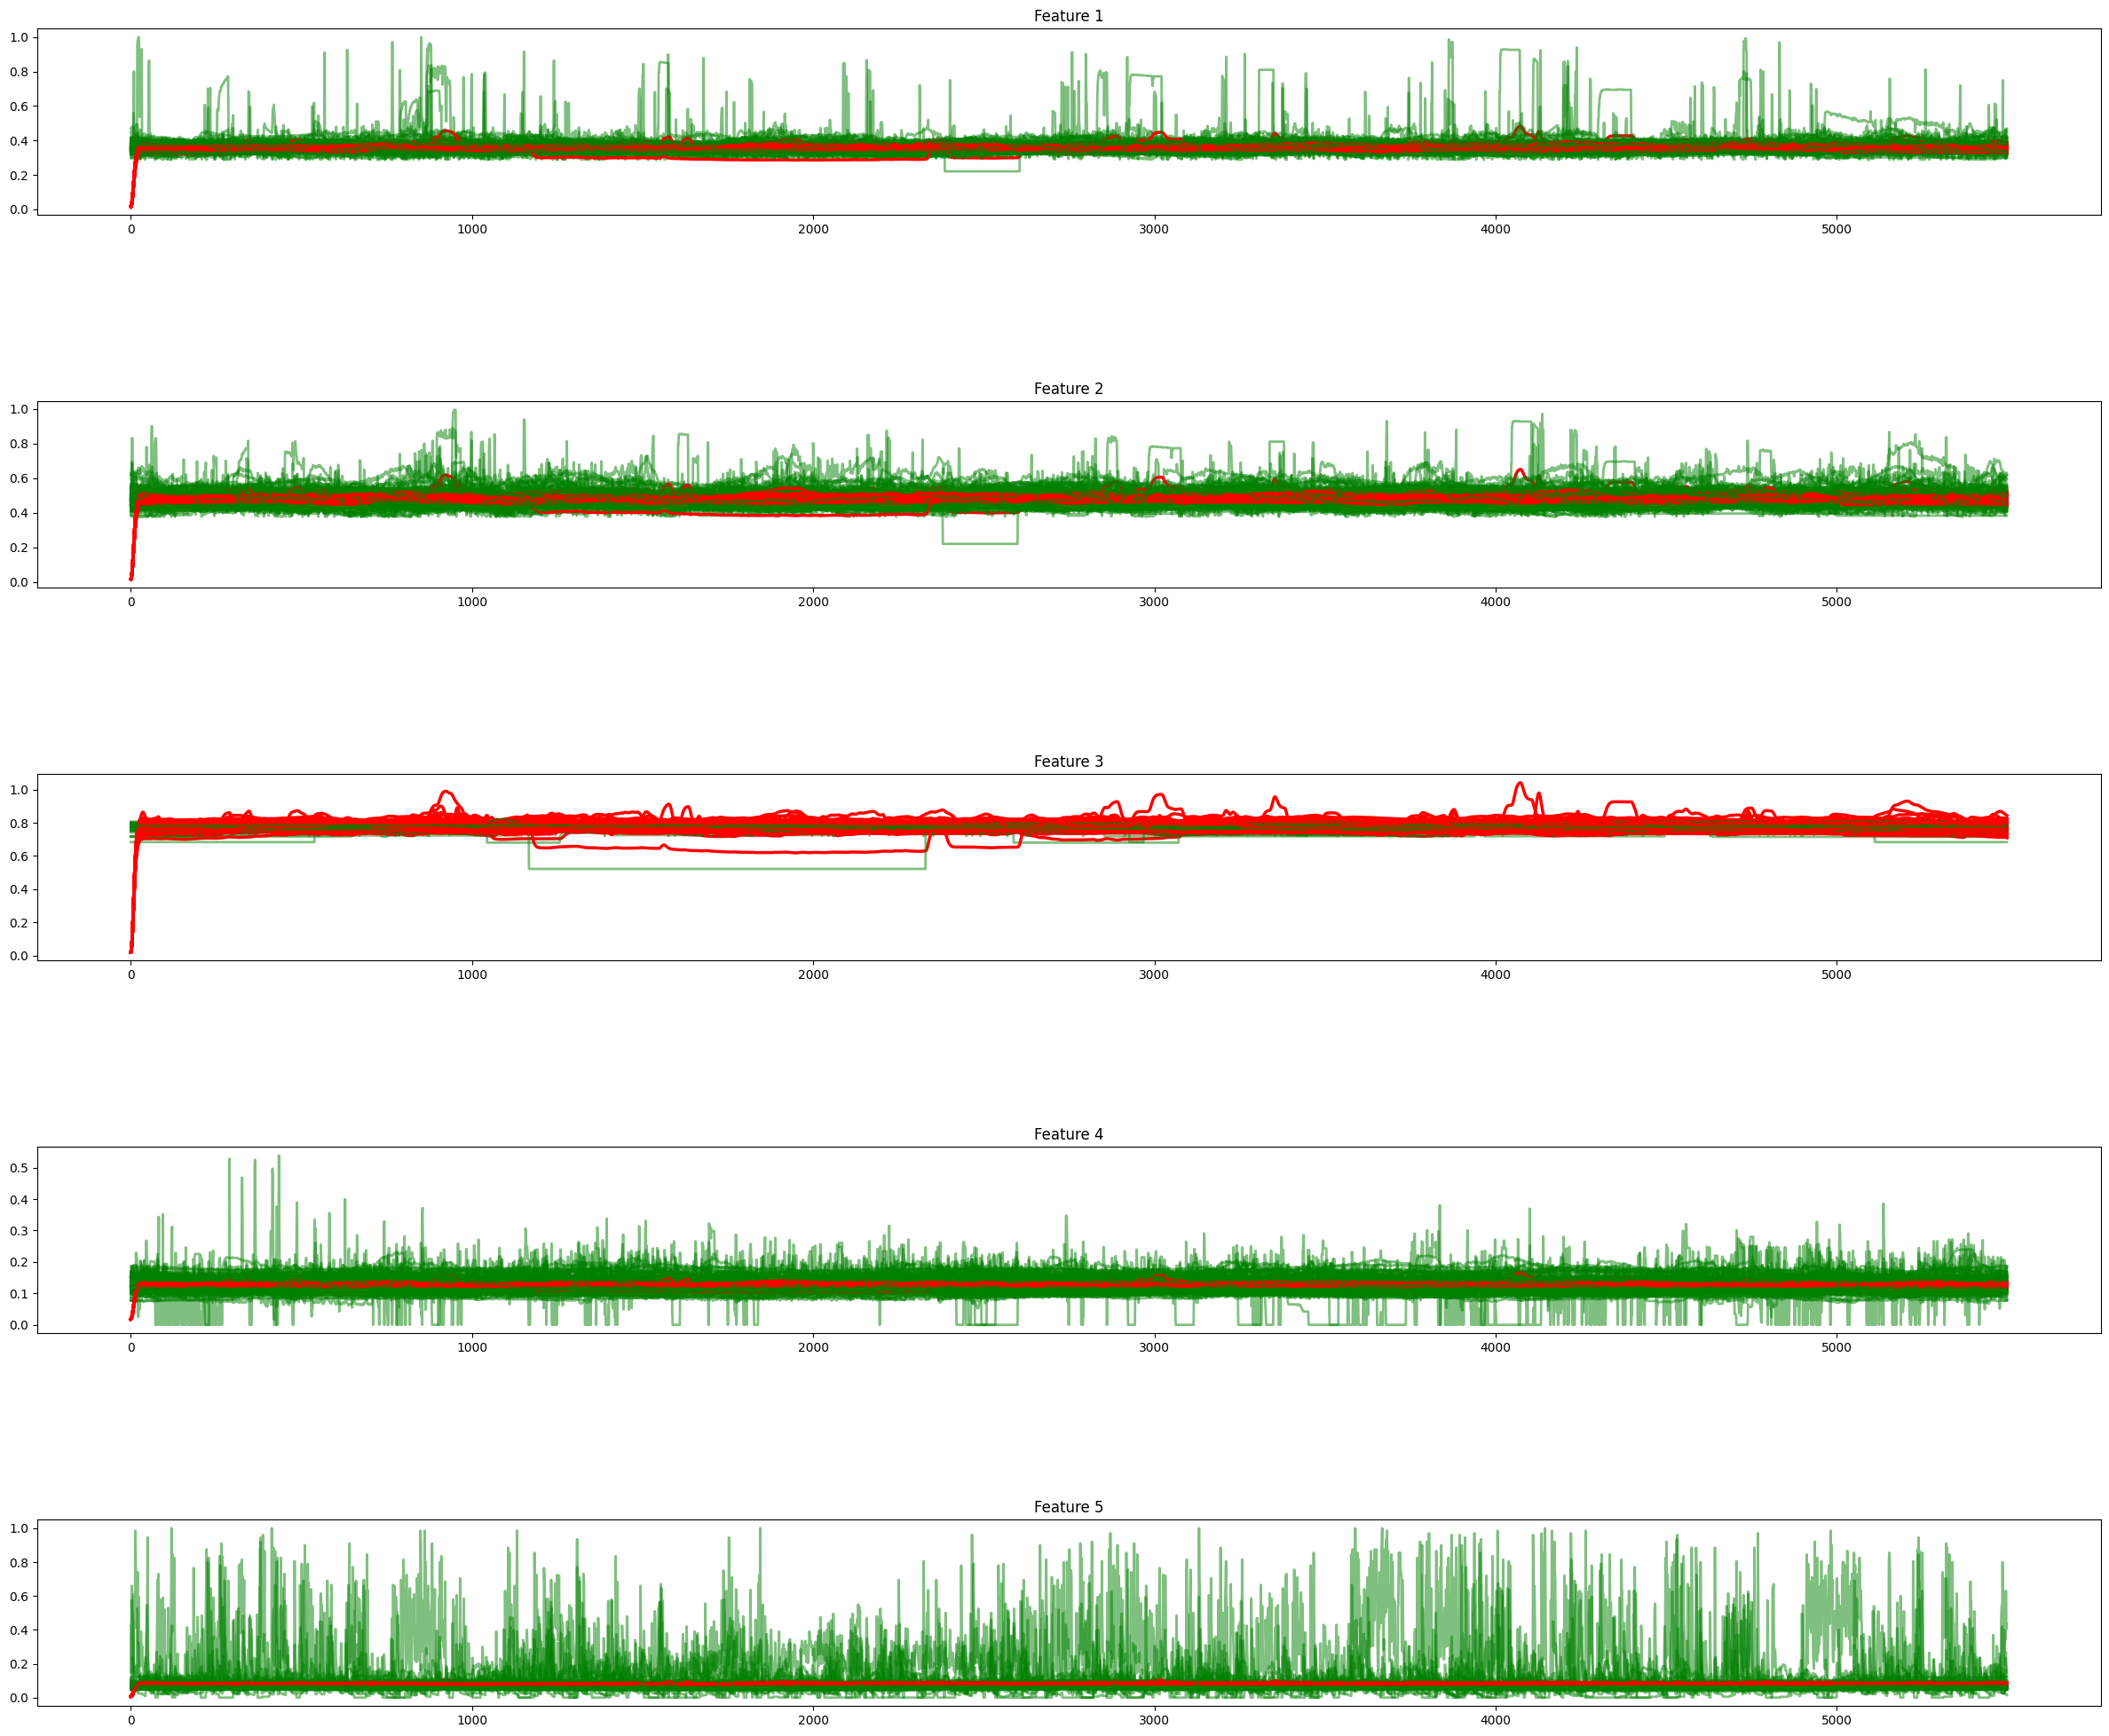


										NOT HEALTHY



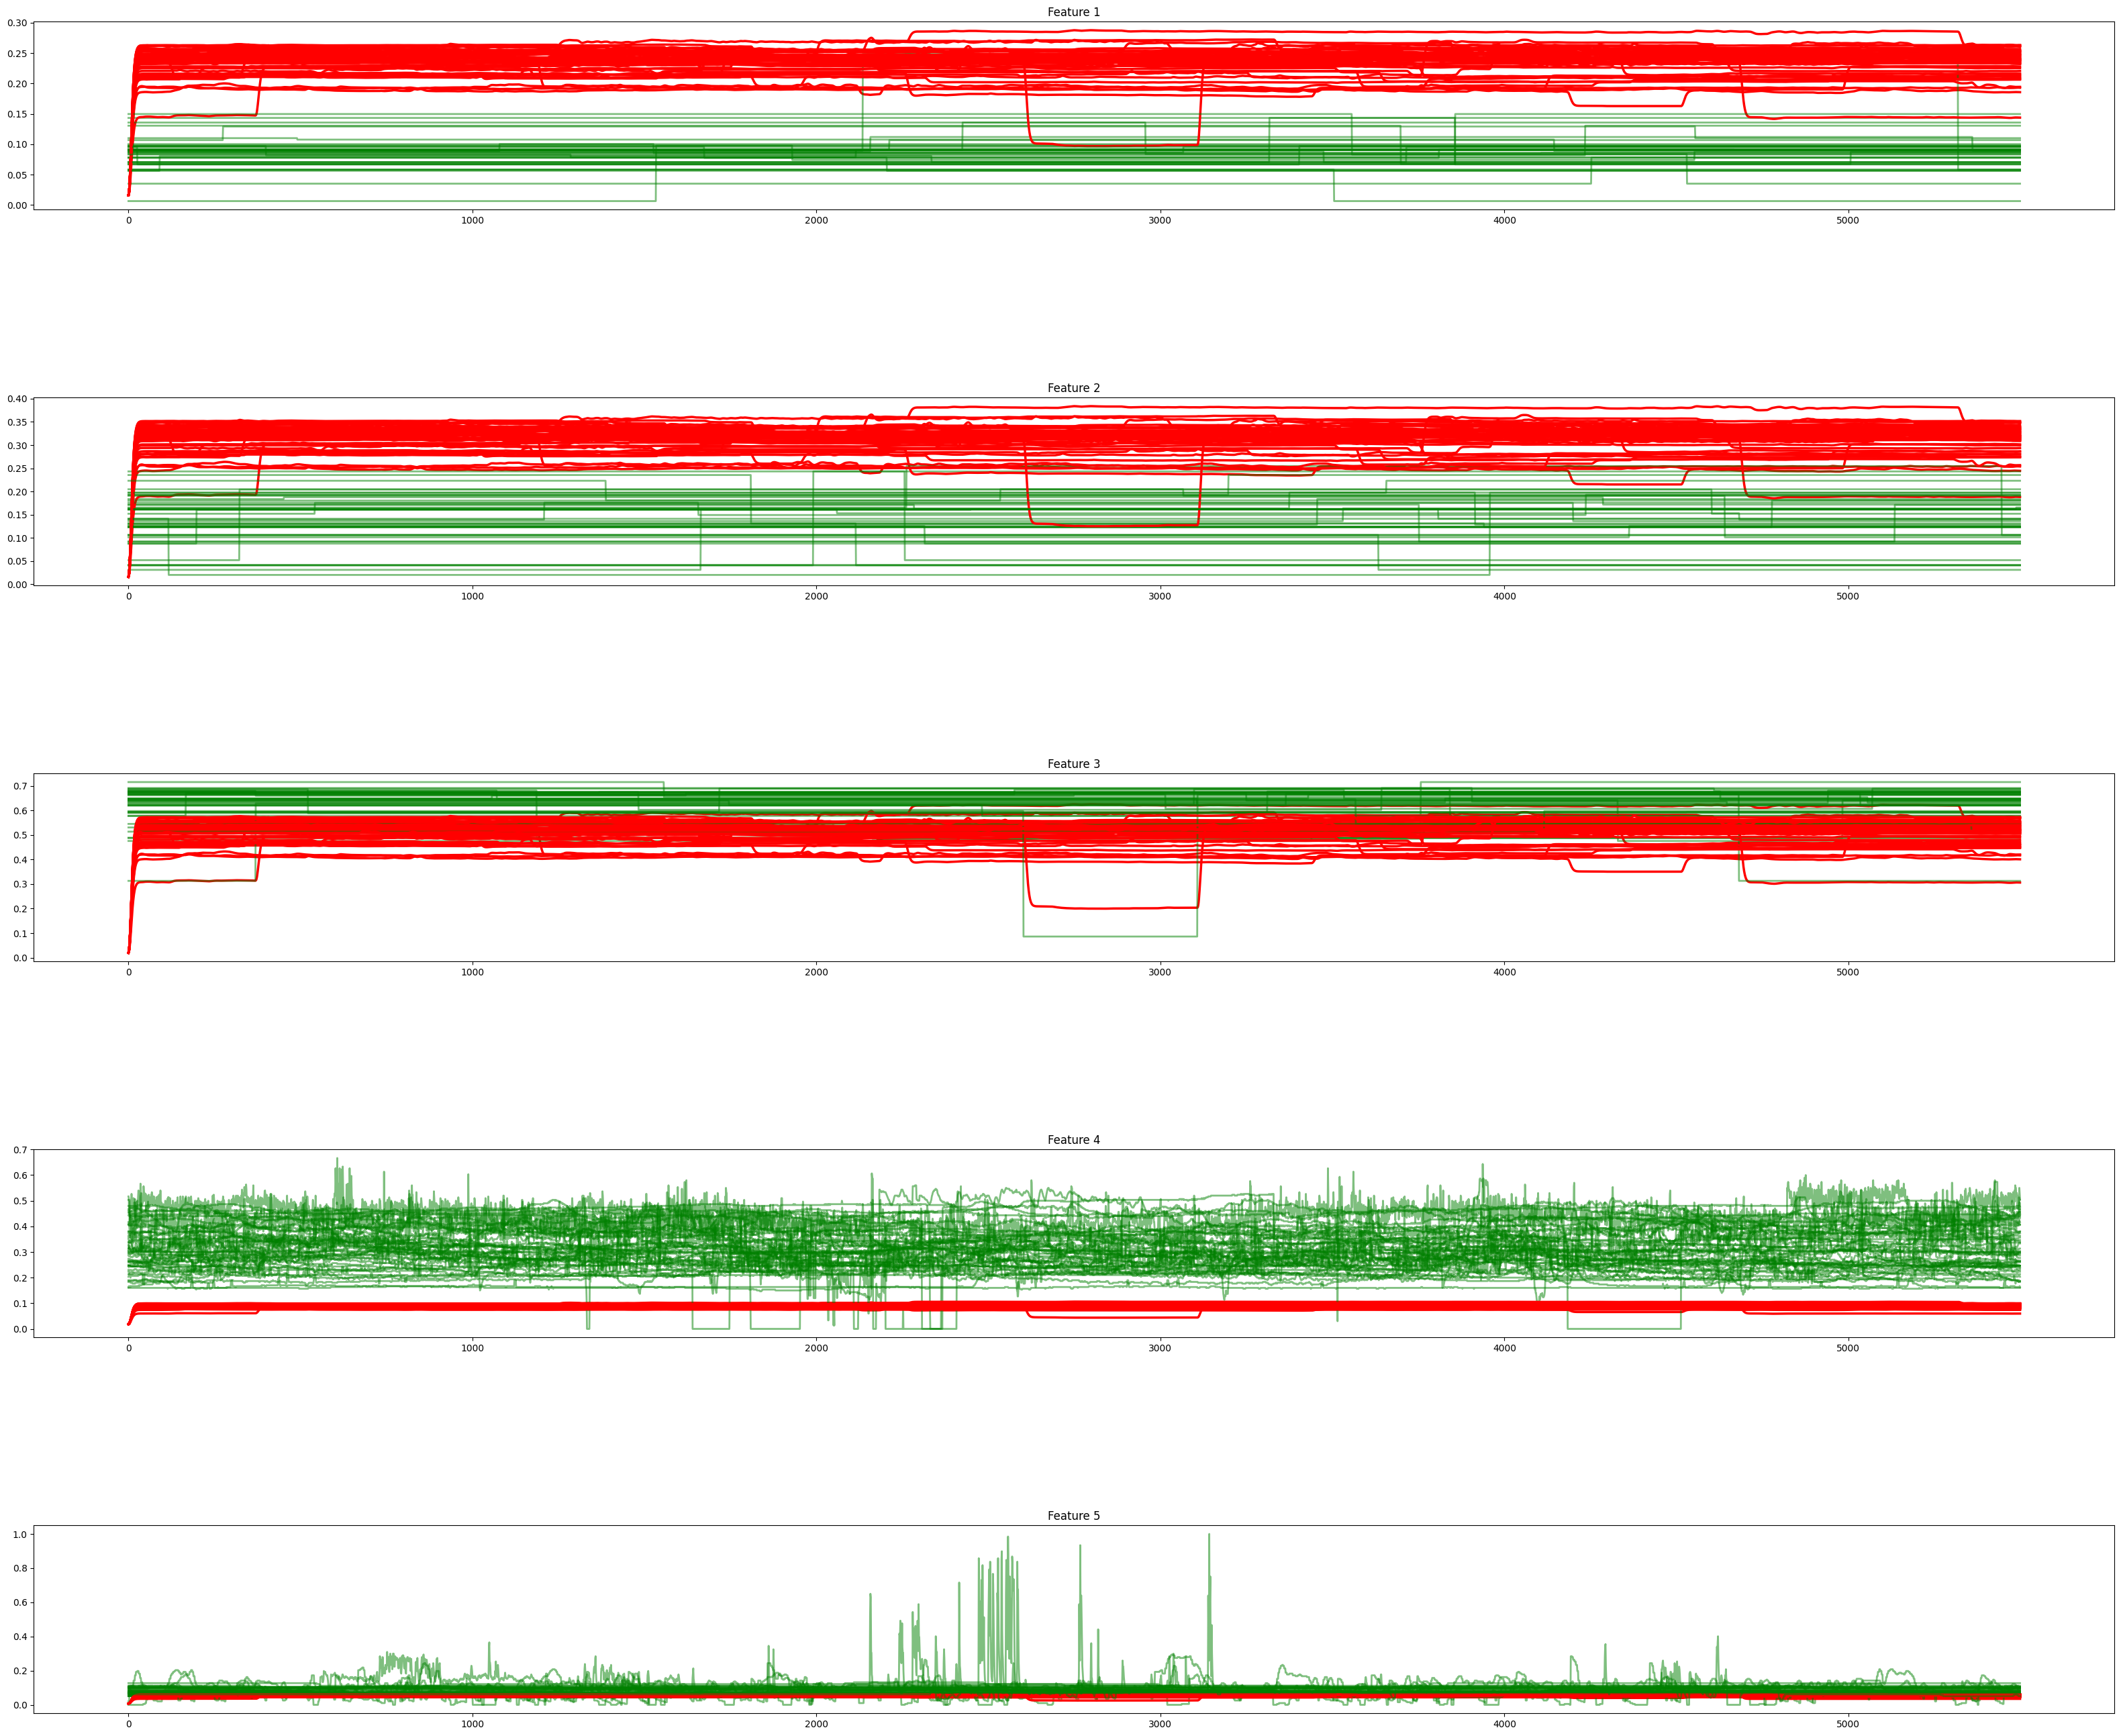

In [68]:
plot_predict(X_test_h,res_h, n = 100, figsize=(30,30))
print("\n\t\t\t\t\t\t\t\t\t\tNOT HEALTHY\n")
plot_predict(X_test_nh,res_nh)

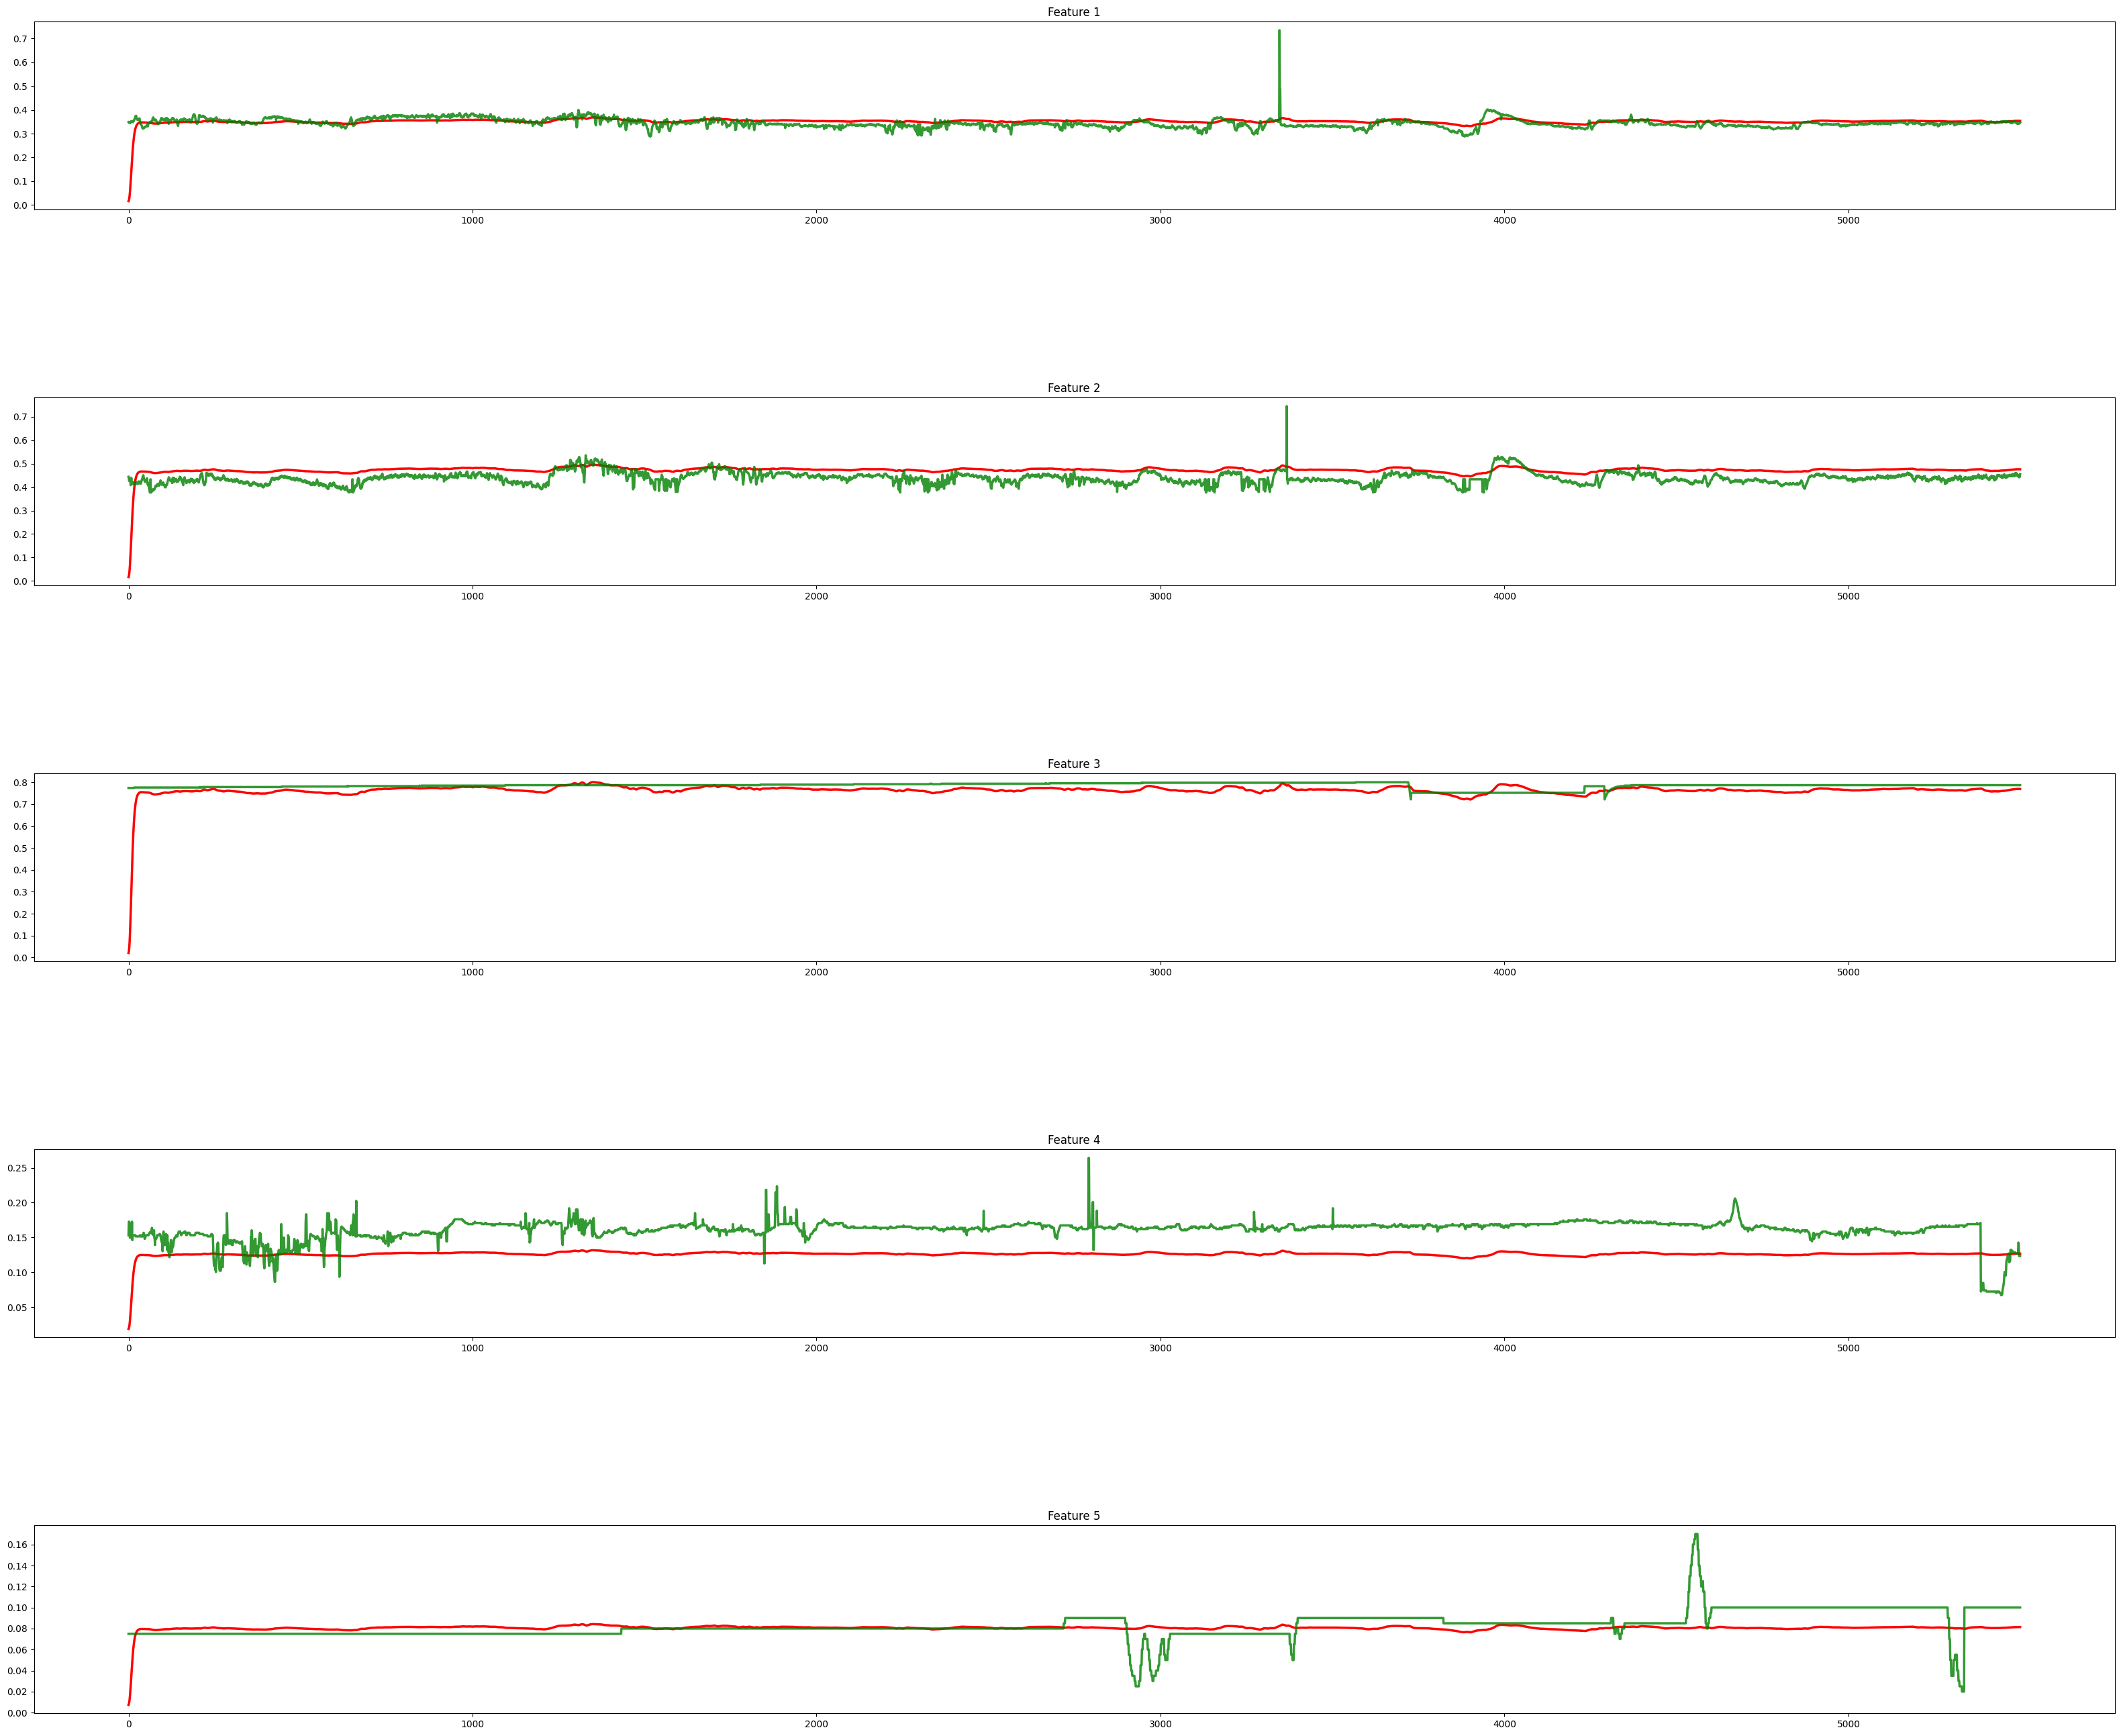

In [52]:
plot_predict(X_test_h, res_h, n=50,single=True)

In [28]:
model.save("/Users/Roberto/projects/AnomalyDetection/models/autoencoder_LSTM_1.h5")
model.save("/Users/Roberto/projects/AnomalyDetection/models/autoencoder_LSTM_1")
rec = tf.keras.models.load_model("/Users/Roberto/projects/AnomalyDetection/models/autoencoder_LSTM_1")

In [85]:

test_ecg,test_dbp,test_sbp,test_bt,test_hr,test_rr   = load_from_API(asa=3, op='==', n_cases=100)
test_ecg,test_dbp,test_sbp,test_bt,test_hr,test_rr   = clean_data(test_ecg,test_dbp,test_sbp,test_bt,test_hr,test_rr)
test_ecg,test_dbp,test_sbp,test_bt,test_hr,test_rr,_ =  normalize(test_ecg,test_dbp,test_sbp,test_bt,test_hr,test_rr) # normalize the test instance with the same approach of train ones

X_test = preprocess(test_ecg,test_dbp,test_sbp,test_bt,test_hr,test_rr)
res_test = model.predict(X_test)
err,dict_means = eval_error(X_test,res_test)


4/4 [==============================] - 34s 8s/step


In [82]:
print("Reconstruction error on features of healthy patients:")
print(dict_means)
print("Mean reconstruction error: " + str(np.round(err,3)))

Reconstruction error on features of healthy patients:
{'sbp': 2.226, 'dbp': 4.229, 'bt': 4.459, 'rr': 11.406, 'hr': 2.367}
Mean reconstruction error: 4.937


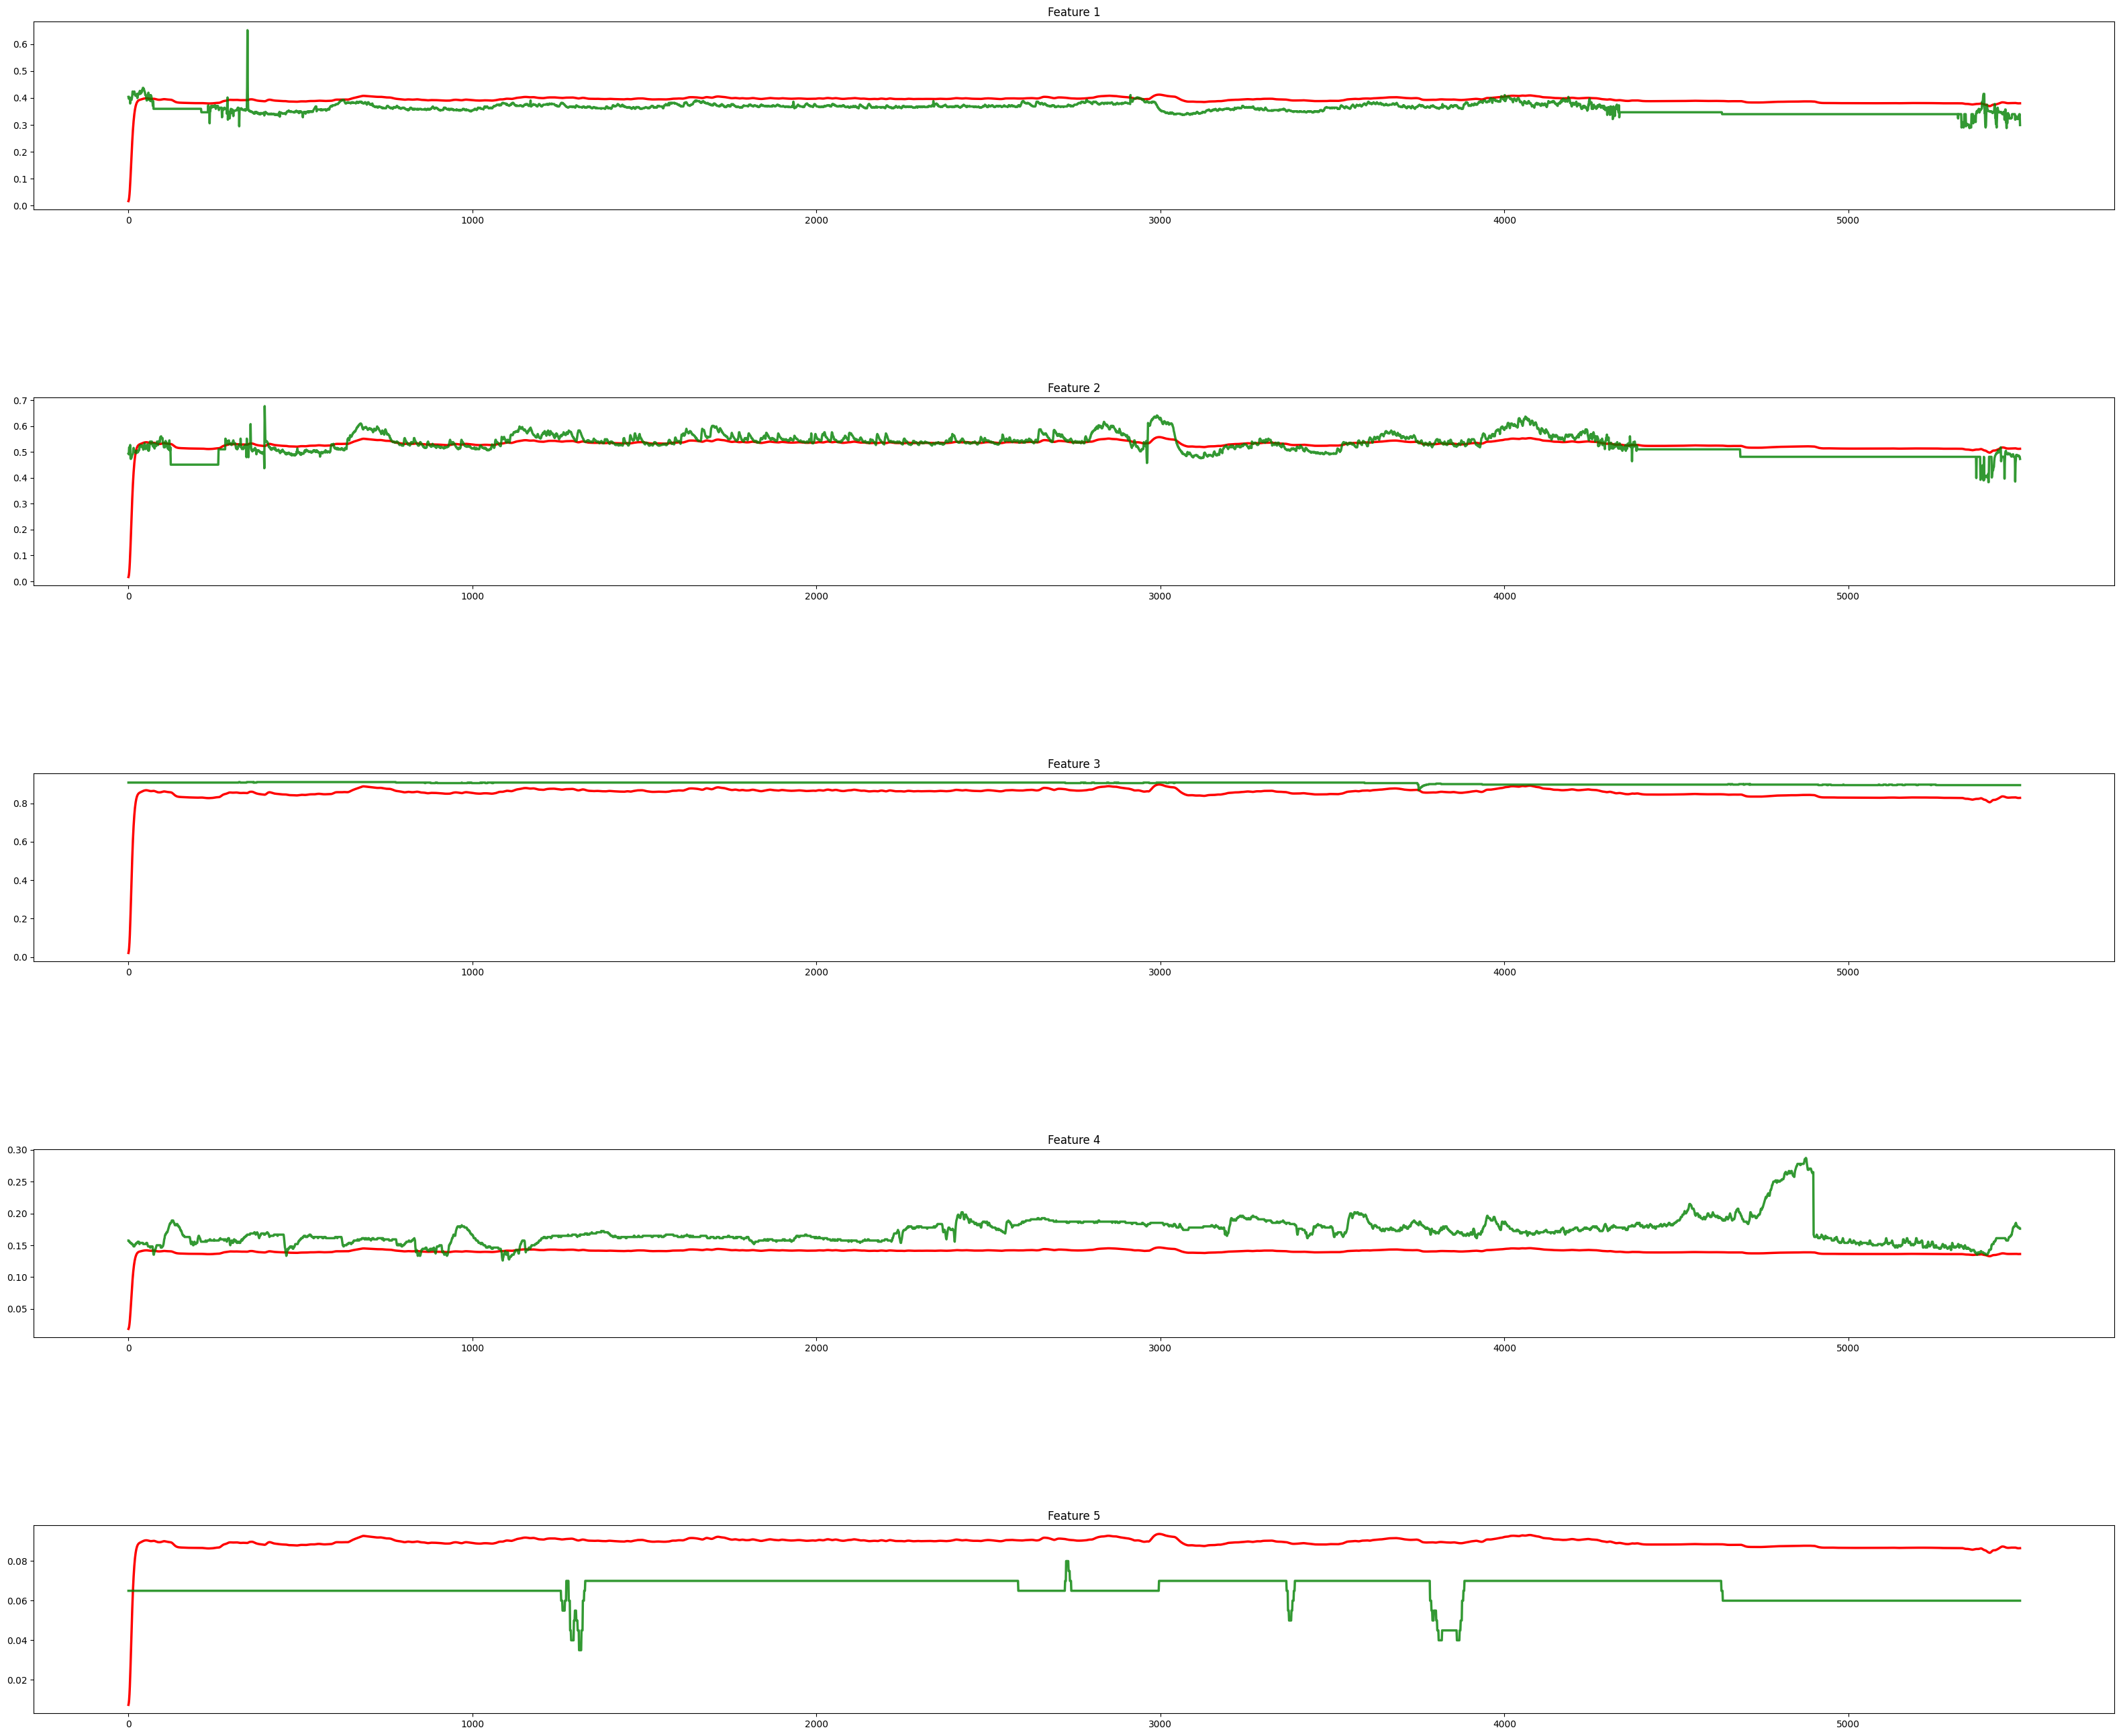

In [89]:
plot_predict(X_test,res_test, n = 70, single = True)